# ResNet50

In [3]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import random
from scipy.stats import pointbiserialr
from  sklearn.preprocessing import OrdinalEncoder
import h5py
import os

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Image Processing
import cv2
from PIL import Image
from io import BytesIO
from skimage.feature import hog

# Deep Learning Modules
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")

#### Feature extraction

read metadata for image path

In [5]:
df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
df.head(5)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [6]:
path_list = [f"/kaggle/input/isic-2024-challenge/train-image/image/{id}.jpg" for id in df.isic_id]
selected_images = np.random.choice(path_list, 3, replace=False)

#### Hair removal

In [8]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    return final_image

show the difference between raw image and hair removal image

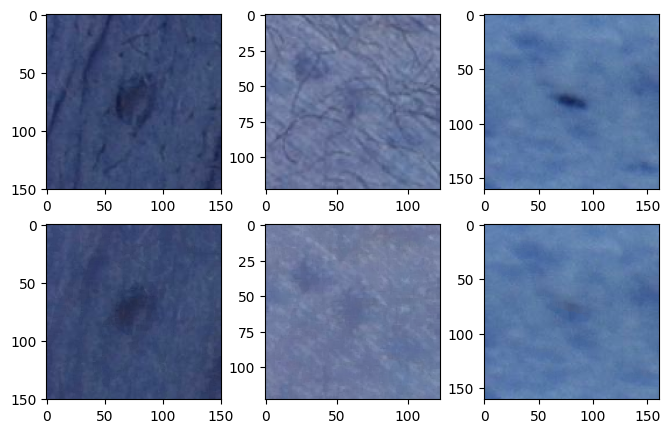

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
for i, path in enumerate(selected_images):
    image = cv2.imread(path)
    axes[0, i].imshow(image)
    axes[1, i].imshow(hair_remove(image))

#### SIFT

In [10]:
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    sift_image = cv2.drawKeypoints(image, keypoints, None)
    return sift_image

show the difference between raw image and sift image

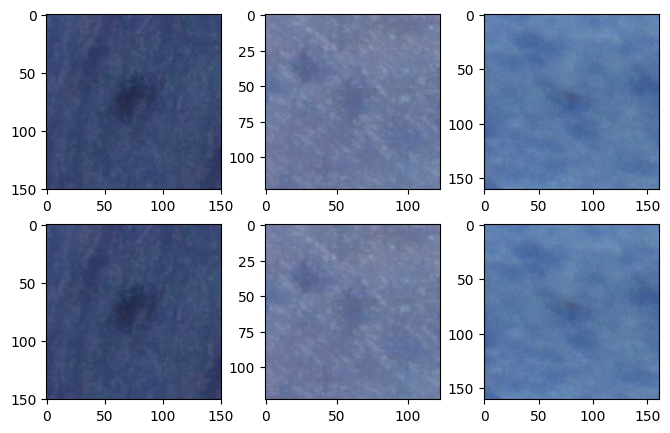

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
for i, path in enumerate(selected_images):
    image = cv2.imread(path)
    image_no_hair = hair_remove(image)
    axes[0, i].imshow(image_no_hair)
    axes[1, i].imshow(extract_sift_features(image_no_hair))

#### HOG

In [12]:
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_image

show the difference between raw image and hog image

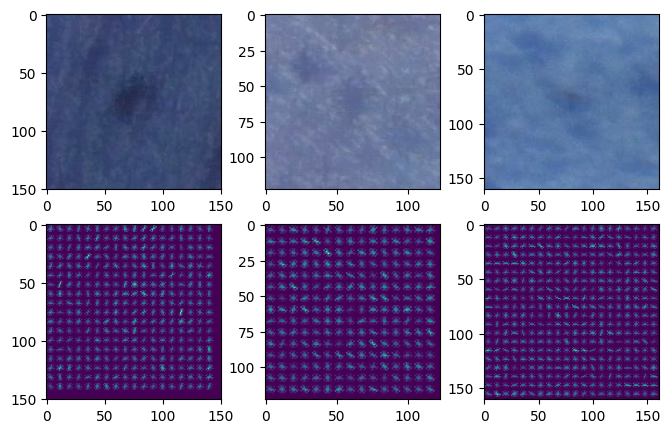

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
for i, path in enumerate(selected_images):
    image = cv2.imread(path)
    image_no_hair = hair_remove(image)
    axes[0, i].imshow(image_no_hair)
    axes[1, i].imshow(extract_hog_features(image_no_hair))

____

In [14]:
df["path_list"] = pd.Series(path_list)
melanoma = df[df["target"] == 1]
nonmelanoma = df[df["target"] == 0].sample(len(melanoma) * 3)

In [15]:
def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

<Axes: xlabel='target', ylabel='count'>

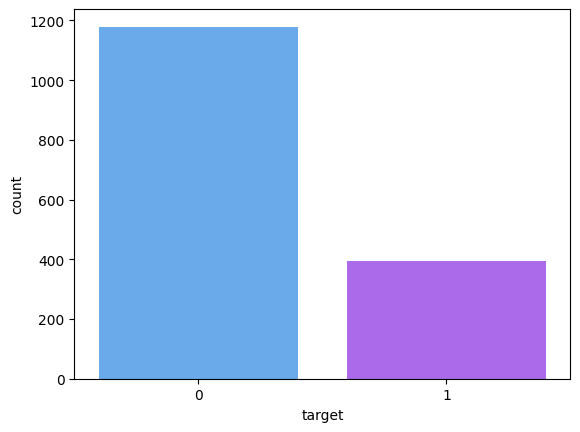

In [17]:
Data = pd.concat([melanoma, nonmelanoma], axis = 0).reset_index(drop = True)
df = Data[["path_list", "target"]]
sns.countplot(x = Data["target"], palette = "cool")

#### Define transforms and dataset

In [18]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(255),
    transforms.ColorJitter(brightness=0.75, contrast=0.75),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
class FlowerDataset(Dataset):
    
    def __init__(self, df, transform = None, Test_mode = False):
        
        self.df = df.reset_index(drop = True)
        self.path = self.df.iloc[:, 0]
        
        self.test_mode = Test_mode
        if self.test_mode == False:
            self.target = self.df.iloc[:, 1]
        self.transform = transform
        
    def __getitem__(self, index):

        img = Image.open(self.path[index])

        
        if transform is not None:
            
            img = transform(img)
            
        target = self.target[index]
        
        
        if self.test_mode == False:
            
            return img, target
        else:
            return img
       
    
    def __len__(self):
        
        return len(self.path)

#### Sample and split data

In [47]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df.iloc[:, 1] = label_encoder.fit_transform(df.iloc[:, 1])

# Mostrar los nombres de las clases y sus correspondientes etiquetas numéricas
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Clase: {class_name}, Etiqueta: {i}")


Train, Test = tts(df, test_size = 0.01/2, stratify = df.iloc[:, 1])
Train, Valid = tts(Train, test_size = 0.1, stratify = Train.iloc[:, 1])

print(f"Train Shape is: {Train.shape}")
print(f"Valid Shape is: {Valid.shape}")
print(f"Test Shape is: {Test.shape}")

print(f"Validation and Test Len is {(Valid.shape[0]  + Test.shape[0]) / df.shape[0] :.2%}")

train_ds = FlowerDataset(Train, transform)
valid_ds = FlowerDataset(Valid, transform_test)
test_ds = FlowerDataset(Test, transform_test)

train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 32, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = 32, shuffle = False)

Clase: 0, Etiqueta: 0
Clase: 1, Etiqueta: 1
Train Shape is: (1407, 2)
Valid Shape is: (157, 2)
Test Shape is: (8, 2)
Validation and Test Len is 10.50%


#### Define train and valid functions

In [46]:
# Training function
def train(model, optimizer, criterion, train_dl, valid_dl, epochs):
    result = []
    val_res = []

    for e in range(epochs):
        print(f"Training the Epoch: {e + 1}")
        model.train()
        total_loss = 0
        total = 0
        correct = 0
        
        for X_train, y_train in train_dl:
            X_train, y_train = X_train.to(device).float(), y_train.to(device).long()
            
            y_pred = model(X_train)
            if isinstance(y_pred, tuple):  # In case of Inception
                y_pred = y_pred[0]
                
            loss = criterion(y_pred, y_train)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y_train.size(0)
            correct += (predicted == y_train).sum().item()
            
        acc_train = 100 * correct / total
        _, val_acc = valid(model, valid_dl, device)
        
        print(f'Epoch: [{e+1}/{epochs}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {val_acc:.2f}')
        result.append(acc_train)
        val_res.append(val_acc)
    
    # Save results to files
    np.savetxt('result.csv', np.array(result), fmt='%.2f', delimiter=',')
    np.savetxt('val_result.csv', np.array(val_res), fmt='%.2f', delimiter=',')  
    
    
    
# Validation Function
def valid(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sample, target in val_loader:
            sample = sample.to(device).float()
            target = target.to(device).long()
            outputs = model(sample)
            _, predicted = torch.max(outputs.data, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_accuracy = 100 * correct / total
    return [], val_accuracy

def plot():
    train_data = np.loadtxt('result.csv', delimiter=',')
    val_data = np.loadtxt('val_result.csv', delimiter=',')
    plt.figure()
    plt.plot(range(1, len(train_data) + 1), train_data, color='blue', label='Train')
    plt.plot(range(1, len(val_data) + 1), val_data, color='red', label='Validation')
    plt.legend()
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Train and Validation Accuracy', fontsize=16)
    plt.savefig('plot.png')
    plt.show()

#### Use pretrained ResNet model

In [21]:
from torchvision import models
Resnet50 = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s] 


#### Define predict function

In [13]:
# Common normalization values used for RGB images in PyTorch
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to denormalize an image
def denormalize(image, mean, std):
    image = image.clone()  # Create a copy to avoid modifying the original
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # Denormalize
    return image

def preds(Model):
    # Example: get a batch of data
    images, targets = next(iter(test_dl))  
    indices = np.arange(len(images))
    np.random.shuffle(indices)

    fig, axes = plt.subplots(8, 2, figsize=(15, 24))  # 16 rows and 2 columns (image and bar plot)
    axes = axes.ravel()

    # Set black background color for all subplots
    for ax in axes:
        ax.set_facecolor('black')

    # Set black background color for the whole figure
    fig.patch.set_facecolor('black')

    # Invert the LabelEncoder dictionary to map integers to labels
    int_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}

    # Calculate accuracy
    correct_predictions = {label: 0 for label in int_to_label.values()}
    total_predictions = {label: 0 for label in int_to_label.values()}

    # Limit the number of iterations to the available number of subplots
    for i in range(min(len(indices), len(axes) // 2)):
        idx = indices[i]
        image, actual_target = images[idx], targets[idx]
        image_tensor = image.to(device).unsqueeze(0)
        output = Model(image_tensor)
        _, prediction = torch.max(output, 1)

        predicted_label = int_to_label[prediction.cpu().item()]  # Convert to class name
        actual_label = int_to_label[actual_target.item()]
        total_predictions[actual_label] += 1
        if predicted_label == actual_label:
            correct_predictions[predicted_label] += 1

        # Convert the image tensor for plotting
        image = denormalize(image, mean, std)
        image = image.permute(1, 2, 0)  # Change dimensions from CxHxW to HxWxC
        image = image.cpu().numpy()

        # Display image
        axes[2 * i].imshow(image)
        axes[2 * i].set_title(f"Actual Label: {actual_label}", color='white')
        axes[2 * i].axis('off')

        # Display bar plot with probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy().flatten()
        bar_colors = ['white'] * len(probabilities)  # Default bar colors

        # Change bar colors based on conditions
        if predicted_label == actual_label:
            bar_colors[np.argmax(probabilities)] = 'aquamarine'  # Correct prediction
        else:
            bar_colors[np.argmax(probabilities)] = 'red'  # Incorrect prediction
            bar_colors[list(int_to_label.values()).index(actual_label)] = 'steelblue'  # Correct label

        axes[2 * i + 1].bar(int_to_label.values(), probabilities, color=bar_colors)
        axes[2 * i + 1].set_ylim(0, 1)
        axes[2 * i + 1].set_title(f"Probabilities for {predicted_label}", color='white')

        # Configure axis colors and annotations
        axes[2 * i + 1].tick_params(axis='x', colors='white')
        axes[2 * i + 1].tick_params(axis='y', colors='white')
        axes[2 * i + 1].spines['bottom'].set_color('white')
        axes[2 * i + 1].spines['top'].set_color('white') 
        axes[2 * i + 1].spines['right'].set_color('white')
        axes[2 * i + 1].spines['left'].set_color('white')
        axes[2 * i + 1].yaxis.label.set_color('white')
        axes[2 * i + 1].xaxis.label.set_color('white')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


In [1]:
# for param in Resnet50.parameters():
#     param.requires_grad = False
    
# features = Resnet50.fc.in_features
# Resnet50.fc = nn.Linear(features, 2)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model = Resnet50.to(device)



# optimizer = optim.SGD(Model.parameters(), lr = 0.003, momentum = 0.9)
# criterion = nn.CrossEntropyLoss()

# train(Model, optimizer, criterion, train_dl, valid_dl, 20)
# plot()
# preds(Model)

### Predict the test dataset

In [48]:
def train(model, optimizer, criterion, train_dl, valid_dl, epochs):
    result = []
    val_res = []
    y_trues = []
    y_probs = []

    for e in range(epochs):
        print(f"Training the Epoch: {e + 1}")
        model.train()
        total_loss = 0
        total = 0
        correct = 0
        
        for X_train, y_train in train_dl:
            X_train, y_train = X_train.to(device).float(), y_train.to(device).long()
            y_pred = model(X_train)
            if isinstance(y_pred, tuple):  # In case of Inception
                y_pred = y_pred[0]
                
            loss = criterion(y_pred, y_train)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y_train.size(0)
            correct += (predicted == y_train).sum().item()
        
        acc_train = 100 * correct / total
        val_acc, y_true, y_prob = valid(model, valid_dl, device)  # 获取验证集的预测值和真实标签
        
        print(f'Epoch: [{e+1}/{epochs}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {val_acc:.2f}')
        result.append(acc_train)
        val_res.append(val_acc)
        
        # 收集每个epoch的验证集预测值
        y_trues.extend(y_true)
        y_probs.extend(y_prob)

    return result, val_res, y_trues, y_probs  # 返回结果、验证集准确率、真实标签和预测概率


In [49]:
def valid(model, valid_dl, device):
    model.eval()
    correct = 0
    total = 0
    y_trues = []
    y_probs = []
    
    with torch.no_grad():
        for X_valid, y_valid in valid_dl:
            X_valid, y_valid = X_valid.to(device).float(), y_valid.to(device).long()
            y_pred = model(X_valid)
            if isinstance(y_pred, tuple):  # In case of Inception
                y_pred = y_pred[0]
                
            _, predicted = torch.max(y_pred.data, 1)
            total += y_valid.size(0)
            correct += (predicted == y_valid).sum().item()
            
            # 收集真实标签和预测概率
            y_trues.extend(y_valid.cpu().numpy())  # 收集真实标签
            y_probs.extend(torch.softmax(y_pred, dim=1)[:, 1].cpu().numpy())  # 收集正类的概率（假设是二分类问题）
    
    acc_val = 100 * correct / total
    return acc_val, y_trues, y_probs  # 返回验证准确率、真实标签和预测概率


In [14]:
for param in Resnet50.parameters():
    param.requires_grad = False
    
features = Resnet50.fc.in_features
Resnet50.fc = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Model = Resnet50.to(device)



optimizer = optim.SGD(Model.parameters(), lr = 0.003, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

train_accs, val_accs, y_true, y_prob = train(Model, optimizer, criterion, train_dl, valid_dl, epochs=20)

Training the Epoch: 1
Epoch: [1/20], Loss: 0.0169, Train Acc: 75.05, Val Acc: 84.08
Training the Epoch: 2
Epoch: [2/20], Loss: 0.0148, Train Acc: 78.54, Val Acc: 84.71
Training the Epoch: 3
Epoch: [3/20], Loss: 0.0141, Train Acc: 79.89, Val Acc: 83.44
Training the Epoch: 4
Epoch: [4/20], Loss: 0.0153, Train Acc: 78.96, Val Acc: 77.71
Training the Epoch: 5
Epoch: [5/20], Loss: 0.0142, Train Acc: 79.53, Val Acc: 80.25
Training the Epoch: 6
Epoch: [6/20], Loss: 0.0137, Train Acc: 80.10, Val Acc: 81.53
Training the Epoch: 7
Epoch: [7/20], Loss: 0.0143, Train Acc: 80.67, Val Acc: 80.25
Training the Epoch: 8
Epoch: [8/20], Loss: 0.0140, Train Acc: 79.67, Val Acc: 84.71
Training the Epoch: 9
Epoch: [9/20], Loss: 0.0136, Train Acc: 80.53, Val Acc: 83.44
Training the Epoch: 10
Epoch: [10/20], Loss: 0.0138, Train Acc: 80.60, Val Acc: 82.17
Training the Epoch: 11
Epoch: [11/20], Loss: 0.0150, Train Acc: 79.46, Val Acc: 81.53
Training the Epoch: 12
Epoch: [12/20], Loss: 0.0145, Train Acc: 80.74, V

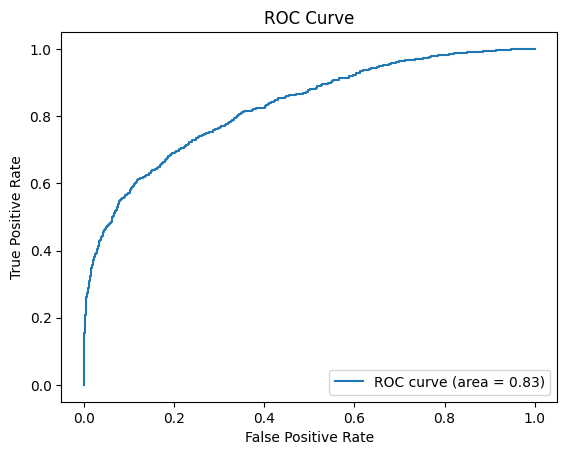

In [15]:
# 现在你可以用 y_true 和 y_prob 来绘制 ROC 曲线
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [58]:
roc_data = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
roc_data.to_csv('/kaggle/working/roc_data_resnet.csv', index=False)

## Parameter tuning

In [15]:
learning_rates = [0.01, 0.003, 0.0005]
momentums = [0.7, 0.8, 0.9]
weight_decays = [0, 1e-4, 1e-6]

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
import csv
import torch
from torch import nn, optim
from sklearn.metrics import roc_auc_score

# Initialize CSV file
csv_file = '/kaggle/working/hyperparameter_tuning_results.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Learning Rate", "Momentum", "Weight Decay", "Train Acc", "Val Acc", "AUROC"])

    # Loop over hyperparameter combinations
    for lr in learning_rates:
        for momentum in momentums:
            for wd in weight_decays:
                print("Current combination [lr=" + str(lr) + ", momentum=" + str(momentum) + ", weight_decay=" + str(wd) + "]")
                # Reload the model to reset weights
                Resnet50 = models.resnet50(pretrained=True)
                for param in Resnet50.parameters():
                    param.requires_grad = False
                features = Resnet50.fc.in_features
                Resnet50.fc = nn.Linear(features, 2)
                Model = Resnet50.to(device)

                # Define optimizer with the current hyperparameters
                optimizer = optim.SGD(Model.parameters(), lr=lr, momentum=momentum, weight_decay=wd)
                criterion = nn.CrossEntropyLoss()

                # Train the model and return the results
                train_accs, val_accs, y_true, y_prob = train(Model, optimizer, criterion, train_dl, valid_dl, epochs=20)
                
                # Compute AUROC
                auroc = roc_auc_score(y_true, y_prob)
                
                # Save the best epoch's results
                best_train_acc = max(train_accs)
                best_val_acc = max(val_accs)
                
                writer.writerow([lr, momentum, wd, best_train_acc, best_val_acc, auroc])

print(f"Hyperparameter tuning results saved to {csv_file}")

Current combination [lr=0.01, momentum=0.7, weight_decay=0]
Training the Epoch: 1
Epoch: [1/20], Loss: 0.0192, Train Acc: 70.50, Val Acc: 80.89
Training the Epoch: 2
Epoch: [2/20], Loss: 0.0171, Train Acc: 75.62, Val Acc: 82.80
Training the Epoch: 3
Epoch: [3/20], Loss: 0.0162, Train Acc: 76.97, Val Acc: 72.61
Training the Epoch: 4
Epoch: [4/20], Loss: 0.0157, Train Acc: 77.47, Val Acc: 79.62
Training the Epoch: 5
Epoch: [5/20], Loss: 0.0160, Train Acc: 78.04, Val Acc: 76.43
Training the Epoch: 6
Epoch: [6/20], Loss: 0.0171, Train Acc: 76.83, Val Acc: 80.89
Training the Epoch: 7
Epoch: [7/20], Loss: 0.0151, Train Acc: 77.68, Val Acc: 80.89
Training the Epoch: 8
Epoch: [8/20], Loss: 0.0160, Train Acc: 78.11, Val Acc: 82.17
Training the Epoch: 9
Epoch: [9/20], Loss: 0.0154, Train Acc: 78.96, Val Acc: 71.97
Training the Epoch: 10
Epoch: [10/20], Loss: 0.0169, Train Acc: 75.84, Val Acc: 78.34
Training the Epoch: 11
Epoch: [11/20], Loss: 0.0153, Train Acc: 79.82, Val Acc: 81.53
Training the

The accuracy and pAUC difference between the worst combination and the best is around 5% and 0.05

____________

## Cross Validation with the best parameter combination

In [30]:
# # a new train function without save the results

# def train(model, optimizer, criterion, train_dl, valid_dl, epochs):
#     result = []
#     val_res = []

#     for e in range(epochs):
#         print(f"Training the Epoch: {e + 1}")
#         model.train()
#         total_loss = 0
#         total = 0
#         correct = 0
        
#         for X_train, y_train in train_dl:
#             X_train, y_train = X_train.to(device).float(), y_train.to(device).long()
#             y_pred = model(X_train)
#             if isinstance(y_pred, tuple):  # In case of Inception
#                 y_pred = y_pred[0]
                
#             loss = criterion(y_pred, y_train)
            
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
            
#             total_loss += loss.item()
#             _, predicted = torch.max(y_pred.data, 1)
#             total += y_train.size(0)
#             correct += (predicted == y_train).sum().item()
            
#         acc_train = 100 * correct / total
#         _, val_acc = valid(model, valid_dl, device)
        
#         print(f'Epoch: [{e+1}/{epochs}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {val_acc:.2f}')
#         result.append(acc_train)
#         val_res.append(val_acc)
    
#     return val_res

In [ ]:
# def valid(model, valid_dl, device):
#     model.eval()
#     correct = 0
#     total = 0
#     y_trues = []
#     y_probs = []
    
#     with torch.no_grad():
#         for X_valid, y_valid in valid_dl:
#             X_valid, y_valid = X_valid.to(device).float(), y_valid.to(device).long()
#             y_pred = model(X_valid)
#             if isinstance(y_pred, tuple):  # In case of Inception
#                 y_pred = y_pred[0]
                
#             _, predicted = torch.max(y_pred.data, 1)
#             total += y_valid.size(0)
#             correct += (predicted == y_valid).sum().item()
            
#             # 收集真实标签和预测概率
#             y_trues.extend(y_valid.cpu().numpy())  # 收集真实标签
#             y_probs.extend(torch.softmax(y_pred, dim=1)[:, 1].cpu().numpy())  # 收集正类的概率（假设是二分类问题）
    
#     acc_val = 100 * correct / total
#     return acc_val, y_trues, y_probs  # 返回验证准确率、真实标签和预测概率


Define pAUC

In [112]:
import numpy as np
from sklearn.metrics import roc_curve, auc

def pAUC(y_true, y_preds, min_tpr: float = 0.80):
    v_gt = abs(np.asarray(y_true)-1)
    v_pred = -1.0 * np.asarray(y_preds)
    max_fpr = abs(1-min_tpr)
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    return partial_auc


In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, recall_score

def stratified_kfold_cv(df, model, fraction, n_splits):
    """
    实现分层交叉验证，适用于图片数据集
    df: 包含图片路径和标签的数据集
    fraction: 数据采样比例
    n_splits: 折数
    """
    sample_df = df.sample(frac=fraction)

    # 按类别分层划分样本数据为 n_splits 份，确保类别比例不变
    classes = np.unique(sample_df.iloc[:, 1])  # 获取类别（假设类别在第2列）
    fold_indices = {i: [] for i in range(n_splits)}  # 初始化每个折的索引存储

    for cls in classes:
        cls_indices = np.where(sample_df.iloc[:, 1] == cls)[0]  # 获取该类别的索引
        np.random.shuffle(cls_indices)  # 打乱顺序
        cls_fold_size = len(cls_indices) // n_splits  # 每份大小

        # 将该类别的样本均匀分布到各个折
        for i in range(n_splits):
            start = i * cls_fold_size
            end = (i + 1) * cls_fold_size if i != n_splits - 1 else len(cls_indices)  # 最后一折包含所有剩余样本
            fold_indices[i].extend(cls_indices[start:end])

    all_results = []
    all_auc = []
    all_pauc = []
    all_recall = []
    all_precision = []

    plt.figure(figsize=(10, 8))  # 设置ROC曲线图大小

    for i in range(n_splits):
        print(f"current fold: {i+1}")
        valid_idx = fold_indices[i]  # 当前的第i折作为验证集
        train_idx = np.concatenate([fold_indices[j] for j in range(n_splits) if j != i])  # 其他折作为训练集
        
        Valid = sample_df.iloc[valid_idx]
        Train = sample_df.iloc[train_idx]

        train_ds = FlowerDataset(Train, transform)
        valid_ds = FlowerDataset(Valid, transform_test)

        train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
        valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)

        # 在该折上训练和验证，使用valid函数获取验证准确率、真实标签和预测概率
        train_accs, val_accs, y_true, y_prob = train(model, optimizer, criterion,
                                                     train_dl, valid_dl, epochs=5)
        
        # 计算ROC曲线
        fpr, tpr, _ = roc_curve(y_true, y_prob)  # y_true为真实标签，y_prob为预测概率
        roc_auc = auc(fpr, tpr)

        # 计算Recall
        y_prob = np.array(y_prob)  # 将y_prob转换为NumPy数组
        y_pred_labels = (y_prob >= 0.5).astype(int)  # 通过阈值0.5获得分类结果
        recall = recall_score(y_true, y_pred_labels)
        # precision
        precision = precision_score(y_true, y_pred_labels)
        
        p_auc = pAUC(y_true, y_pred_labels)

        # 存储AUC、pAUC和Recall结果
        all_auc.append(roc_auc)
        all_pauc.append(p_auc)
        all_recall.append(recall)
        all_precision.append(precision)
        
        # 绘制每个折的ROC曲线
        plt.plot(fpr, tpr, lw=2, label=f'Fold {i+1}')
        all_results.append(val_accs)  # 假设这里是每折验证集的准确率等结果
    
    # 绘制对角线
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Fold')
    plt.legend(loc='lower right')
    plt.show()

    # 计算每折的均值和方差
    mean_result = np.mean(all_results)
    variance_result = np.var(all_results)
    mean_auc_result = np.mean(all_auc)
    mean_pauc_result = np.mean(all_pauc)
    mean_recall_result = np.mean(all_recall)
    mean_precision_result = np.mean(all_precision)
    
    print(f"\final results：\n acc mean = {mean_result}, acc variance = {variance_result}")
    print(f"mean Recall: {mean_recall_result}, mean precision: {mean_precision_result}")
    
    # 返回所有fold的Recall和pAUC
    return all_recall, all_pauc, all_auc, mean_result, variance_result


In [103]:
for param in Resnet50.parameters():
    param.requires_grad = False
    
features = Resnet50.fc.in_features
Resnet50.fc = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Model = Resnet50.to(device)

optimizer = optim.SGD(Model.parameters(), lr = 0.0005, momentum = 0.8, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

current fold: 1
Training the Epoch: 1
Epoch: [1/5], Loss: 0.0121, Train Acc: 83.61, Val Acc: 81.82
Training the Epoch: 2
Epoch: [2/5], Loss: 0.0121, Train Acc: 83.41, Val Acc: 84.42
Training the Epoch: 3
Epoch: [3/5], Loss: 0.0122, Train Acc: 82.61, Val Acc: 88.31
Training the Epoch: 4
Epoch: [4/5], Loss: 0.0124, Train Acc: 82.81, Val Acc: 85.71
Training the Epoch: 5
Epoch: [5/5], Loss: 0.0120, Train Acc: 83.75, Val Acc: 89.61
current fold: 2
Training the Epoch: 1
Epoch: [1/5], Loss: 0.0119, Train Acc: 83.61, Val Acc: 83.12
Training the Epoch: 2
Epoch: [2/5], Loss: 0.0118, Train Acc: 83.28, Val Acc: 84.42
Training the Epoch: 3
Epoch: [3/5], Loss: 0.0120, Train Acc: 84.28, Val Acc: 85.71
Training the Epoch: 4
Epoch: [4/5], Loss: 0.0118, Train Acc: 84.15, Val Acc: 83.12
Training the Epoch: 5
Epoch: [5/5], Loss: 0.0119, Train Acc: 84.08, Val Acc: 84.42
current fold: 3
Training the Epoch: 1
Epoch: [1/5], Loss: 0.0124, Train Acc: 83.21, Val Acc: 77.92
Training the Epoch: 2
Epoch: [2/5], Los

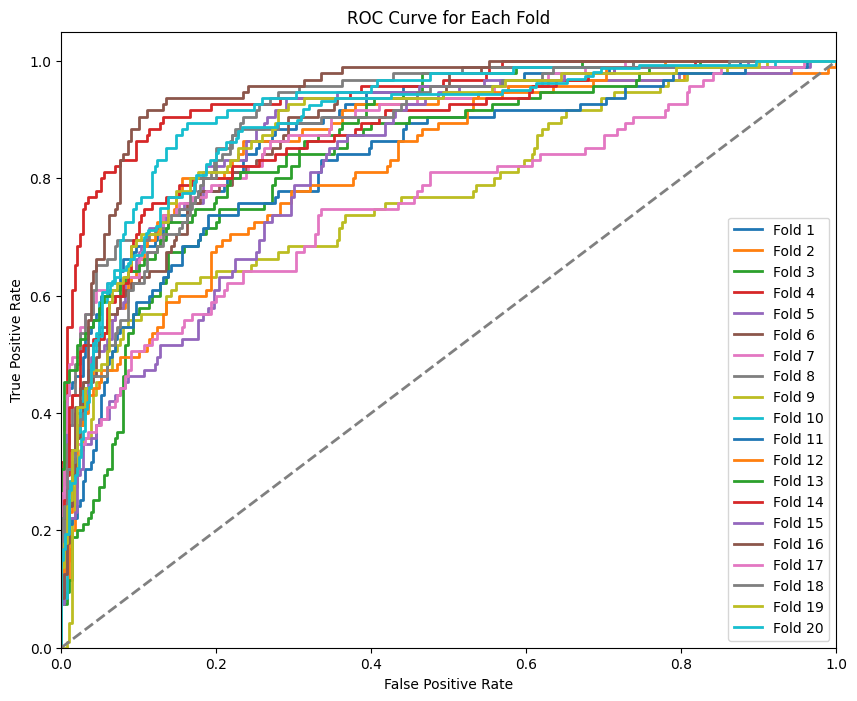

inal results：
 acc mean = 84.13761467889908, acc variance = 12.17766308777822
mean Recall: 0.5024671052631577, mean precision: 0.7846708952357226


In [119]:
all_recall, all_pauc, all_auc, mean_result, variance_result = stratified_kfold_cv(df=df, model=Model, fraction=1, n_splits=20)

-----

## Final result of the resnet50

----------------------

In [70]:
train_accs, val_accs, y_true, y_prob = train(Model, optimizer, criterion, train_dl, valid_dl, epochs=20)

Training the Epoch: 1
Epoch: [1/20], Loss: 0.0175, Train Acc: 75.05, Val Acc: 66.24
Training the Epoch: 2
Epoch: [2/20], Loss: 0.0149, Train Acc: 78.46, Val Acc: 78.34
Training the Epoch: 3
Epoch: [3/20], Loss: 0.0157, Train Acc: 78.89, Val Acc: 77.71
Training the Epoch: 4
Epoch: [4/20], Loss: 0.0137, Train Acc: 81.38, Val Acc: 77.71
Training the Epoch: 5
Epoch: [5/20], Loss: 0.0140, Train Acc: 82.37, Val Acc: 77.07
Training the Epoch: 6
Epoch: [6/20], Loss: 0.0137, Train Acc: 79.96, Val Acc: 82.80
Training the Epoch: 7
Epoch: [7/20], Loss: 0.0136, Train Acc: 82.02, Val Acc: 73.89
Training the Epoch: 8
Epoch: [8/20], Loss: 0.0134, Train Acc: 81.66, Val Acc: 78.34
Training the Epoch: 9
Epoch: [9/20], Loss: 0.0130, Train Acc: 80.74, Val Acc: 78.34
Training the Epoch: 10
Epoch: [10/20], Loss: 0.0156, Train Acc: 78.68, Val Acc: 78.34
Training the Epoch: 11
Epoch: [11/20], Loss: 0.0151, Train Acc: 79.32, Val Acc: 78.34
Training the Epoch: 12
Epoch: [12/20], Loss: 0.0149, Train Acc: 79.03, V